#### VGG 16 

In [0]:
# importing the libraries
%%capture
import os
import sys
import random
import numpy as np
import pandas as pd
import cv2
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
# mounting the google drive to access the chest dataset
from google.colab import drive
drive.mount('/content/gdrive')
!ls 'gdrive/My Drive/Chest/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
test  train  val


In [0]:
# setting data path data seperated by class name
training_dir = 'gdrive/My Drive/Chest/train'
testing_dir = 'gdrive/My Drive/Chest/test'
validation_dir = 'gdrive/My Drive/Chest/val'

In [0]:
from keras.preprocessing.image import ImageDataGenerator

In [5]:
#data augmentation
rescale = 1./255
train_datagen = ImageDataGenerator(
    rescale=rescale,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
print("Training...")
train_generator = train_datagen.flow_from_directory(
   training_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')
print("Validation...")
validation_datagen = ImageDataGenerator(rescale=rescale)
validation_generator = validation_datagen.flow_from_directory(
   validation_dir,
    target_size=(224, 224),
    batch_size=32)

Training...
Found 5216 images belonging to 2 classes.
Validation...
Found 320 images belonging to 2 classes.


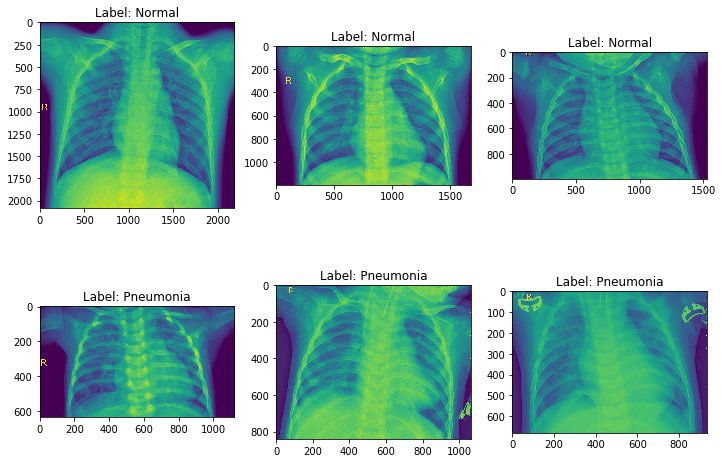

In [24]:
input_path = '/content/gdrive/My Drive/Chest/'
fig, ax = plt.subplots(2, 3, figsize=(10, 7))
ax = ax.ravel()
plt.tight_layout()
for i, _set in enumerate(['train', 'val', 'test']):
    set_path = input_path+_set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]))
    ax[i].set_title('Label: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]))
    ax[i+3].set_title('Label: Pneumonia'.format(_set))

In [0]:
# importing the libraries from keras to build the model
from keras import optimizers
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras import initializers

In [7]:
# # using the VGG 16 model using the imagenet weights
from keras.applications.vgg16 import VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape = (224,224,3))
result = base_model.output
# result = BatchNormalization()(result)
result = Flatten()(result)
# # result = Dropout(0.5)(result)
# # result = Dense(512, activation='relu', kernel_initializer='random_uniform')(result)
# # # add a fully-connected layer
result = Dense(512, activation='relu')(result)
result = BatchNormalization()(result)
result = Dense(64, activation='relu')(result)
result = BatchNormalization()(result)
# and a fully connected output/classification layer
predictions = Dense(2, activation='softmax')(result)
model = Model(inputs=base_model.input, outputs=predictions)
# # first: train only the top layers (which were randomly initialized)
# # i.e. freeze all convolutional layers
# # for layer in base_model.layers:
# #     layer.trainable = False
# for i, layer in enumerate(base_model.layers):
#    print(i, layer.name)
# #choose how many layers how many layers want to be freezed
# for layer in model.layers[:4]:
#    layer.trainable = False
# for layer in model.layers[4:]:
#    layer.trainable = True
model.summary()

58892288/58889256 [==============================] - 31s 1us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________________________________________

In [0]:
from sklearn.utils import class_weight
def get_weight(y):
    class_weight_current =  class_weight.compute_class_weight('balanced', np.unique(y), y)
    return class_weight_current

In [9]:
class_weight = get_weight(train_generator.classes)
class_weight

array([1.9448173 , 0.67303226])

In [0]:
# model complilation using SGD optimizer
from keras.optimizers import Adam
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.0001),metrics=['accuracy'])
# model.load_weights('/content/gdrive/My Drive/vgg16.h5') 

In [0]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
filepath="vgg16_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss',save_best_only=True, verbose=1)
reduce_on_plateau = ReduceLROnPlateau(monitor="val_loss", mode="min", factor=0.1, patience=4, verbose=1)
early_stopping = EarlyStopping( monitor='val_loss',patience=10,verbose=1,restore_best_weights=True)
callbacks_list = [checkpoint,reduce_on_plateau, early_stopping ]

In [12]:
history = model.fit_generator(train_generator, epochs=50,
                              callbacks=callbacks_list,
                              verbose = 1,shuffle= True, 
                              validation_data = validation_generator, workers=-1)

Epoch 1/50
163/163 [==============================] - 2241s 14s/step - loss: 0.3247 - acc: 0.8915 - val_loss: 3.5114 - val_acc: 0.6312

Epoch 00001: val_loss improved from inf to 3.51140, saving model to vgg16_weights.hdf5
Epoch 2/50
163/163 [==============================] - 278s 2s/step - loss: 0.2001 - acc: 0.9431 - val_loss: 1.4564 - val_acc: 0.6219

Epoch 00002: val_loss improved from 3.51140 to 1.45643, saving model to vgg16_weights.hdf5
Epoch 3/50
163/163 [==============================] - 275s 2s/step - loss: 0.1697 - acc: 0.9505 - val_loss: 0.2105 - val_acc: 0.9313

Epoch 00003: val_loss improved from 1.45643 to 0.21052, saving model to vgg16_weights.hdf5
Epoch 4/50
163/163 [==============================] - 278s 2s/step - loss: 0.1576 - acc: 0.9492 - val_loss: 0.7731 - val_acc: 0.8250

Epoch 00004: val_loss did not improve from 0.21052
Epoch 5/50
163/163 [==============================] - 276s 2s/step - loss: 0.1179 - acc: 0.9655 - val_loss: 0.2001 - val_acc: 0.9187

Epoch 00

In [0]:
# load weights
model.load_weights('/content/vgg16_weights.hdf5')

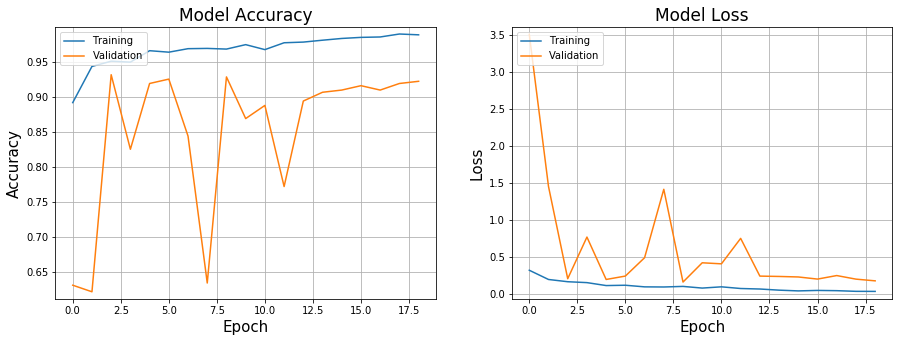

In [14]:
# plotting the accuracy vs loss with the number of Epochs
xlabel = 'Epoch'
legends = ['Training', 'Validation']

ylim_pad = [0.01, 0.1]

plt.figure(figsize=(15, 5))

# Plot training & validation Accuracy values

y1 = history.history['acc']
y2 = history.history['val_acc']

min_y = min(min(y1), min(y2))-ylim_pad[0]
max_y = max(max(y1), max(y2))+ylim_pad[0]


plt.subplot(121)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Accuracy', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()

                         
# Plot training & validation loss values
    
y1 = history.history['loss']
y2 = history.history['val_loss']

min_y = min(min(y1), min(y2))-ylim_pad[1]
max_y = max(max(y1), max(y2))+ylim_pad[1]
    
    
plt.subplot(122)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Loss', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()
                         
plt.show()

In [15]:
# data augmentation of the test images
rescale = 1./255
test_gen = ImageDataGenerator(rescale=rescale)
test_generator = test_gen.flow_from_directory(
    testing_dir,
    target_size=(224, 224),
    batch_size=1,
    shuffle=False,
    class_mode='categorical')
print(test_generator.class_indices)

Found 320 images belonging to 2 classes.
{'NORMAL': 0, 'PNEUMONIA': 1}


In [16]:
 # Evaluating the Test Images 
print("Results")
result  = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1, workers=5)
print("%s%.2f  "% ("Loss     : ", result[0]))
print("%s%.2f%s"% ("Accuracy : ", result[1]*100, "%"))

Results
320/320 [==============================] - 29s 89ms/step
Loss     : 0.26  
Accuracy : 90.31%


In [17]:
# Predicting the test images 
predictions = model.predict_generator(test_generator, steps=len(test_generator), verbose=1, workers=-1)
print(predictions.shape)
y_pred = np.argmax(predictions, axis=1)
y_test = test_generator.classes

320/320 [==============================] - 13s 40ms/step
(320, 2)


In [18]:
# classication_report( precission, recall, accuracy, F1-score)
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
print("Classification Report")
report = classification_report(y_test, y_pred, target_names=['NORMAL', 'PNEUMONIA'])
print(report)

Classification Report
              precision    recall  f1-score   support

      NORMAL       0.95      0.79      0.86       121
   PNEUMONIA       0.88      0.97      0.93       199

    accuracy                           0.90       320
   macro avg       0.92      0.88      0.89       320
weighted avg       0.91      0.90      0.90       320



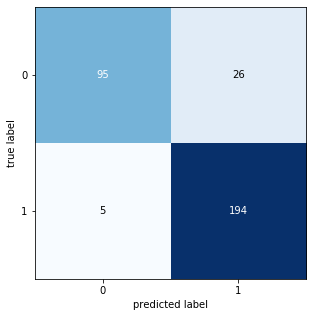

In [19]:
# confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
CM = confusion_matrix(y_test, y_pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [20]:
from sklearn.metrics import accuracy_score
tn, fp, fn, tp = CM.ravel()
print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)
recall = tp/(tp+fn)
# print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((history.history['acc'][-1])*100, 2)))


TEST METRICS ----------------------
Precision: 0.8818181818181818%
Recall: 0.9748743718592965%
F1-score: 0.9260143198090692

TRAIN METRIC ----------------------
Train acc: 98.81
